In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk import WordNetLemmatizer
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.optimizers import Adam

## Urdu hack

In [61]:
pip install urduhack

In [62]:
import urduhack
from urduhack.normalization import normalize
from urduhack.preprocessing import normalize_whitespace,remove_punctuation,remove_accents,replace_urls,replace_emails,replace_numbers,replace_currency_symbols

from urduhack.models.lemmatizer import lemmatizer

In [63]:
urduhack.download()

## Reading files

In [64]:
urdu_dataset = pd.read_csv("urdu-sentiment-corpus-v1.tsv",sep="\t")
urdu_dataset.head()

,Tweet,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N
2,ٹویٹر کا خیال کیسے آیا ؟,O
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P


In [65]:
urdu_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   1000 non-null   object
 1   Class   999 non-null    object
dtypes: object(2)
memory usage: 15.8+ KB


## Removing null values

In [66]:
print(urdu_dataset.isna().sum())
null_check = urdu_dataset.isna().sum().sum()>0
if null_check:
    urdu_dataset.dropna(inplace=True)
    print("After Null values Removed\n",urdu_dataset.isna().sum())

Tweet    0
Class    1
dtype: int64
After Null values Removed
 Tweet    0
Class    0
dtype: int64


In [67]:
urdu_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   999 non-null    object
 1   Class   999 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


## Values counts

In [68]:
urdu_dataset.Class.value_counts()

N    499
P    480
O     20
Name: Class, dtype: int64

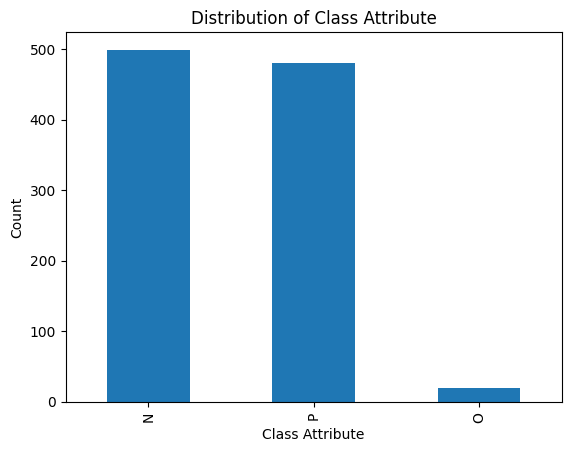

In [69]:
urdu_dataset['Class'].value_counts().plot(kind='bar')

plt.xlabel('Class Attribute')
plt.ylabel('Count')
plt.title('Distribution of Class Attribute')

plt.show()

## Label Encoding Class Attribute

In [70]:
label_encoder = LabelEncoder()
urdu_dataset['Encoded_Class'] = label_encoder.fit_transform(urdu_dataset['Class'])

print(urdu_dataset['Encoded_Class'].unique())
#0 -> Negative
#2 -> Positive
#1 -> Neutral

[2 0 1]


In [71]:
urdu_dataset.Encoded_Class.value_counts()

0    499
2    480
1     20
Name: Encoded_Class, dtype: int64

## Preprocessing
#0 -> Negative
#2 -> Positive
#1 -> Neutral

In [72]:
urdu_dataset.head()

,Tweet,Class,Encoded_Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,P,2
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,N,0
2,ٹویٹر کا خیال کیسے آیا ؟,O,1
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",P,2
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,P,2


In [73]:

file_path = 'my_urdu_stopwords.txt'
STOP_WORDS= ""
with open(file_path,'r',encoding='utf-8')as file:
    urdu_stop_words = file.read().strip()
    STOP_WORDS+=urdu_stop_words
stopword = STOP_WORDS.split()
print(stopword)

['اب', 'ابھی', 'اپنا', 'اپنے', 'اپنی', 'اٹھا', 'اس', 'اسے', 'اسی', 'اگر', 'ان', 'انہوں', 'انہی', 'انہیں', 'انھیں', 'او', 'اور', 'اے', 'ایسا', 'ایسے', 'ایسی', 'ایک', 'آ', 'آپ', 'آتا', 'آتے', 'آتی', 'آگے', 'آنا', 'آنے', 'آنی', 'آئے', 'آئی', 'آئیں', 'آیا', 'با', 'بڑا', 'بڑے', 'بڑی', 'بعد', 'بعض', 'بلکہ', 'بہت', 'بھی', 'بے', 'پاس', 'پر', 'پہلے', 'پھر', 'تا', 'تاکہ', 'تب', 'تجھ', 'تجھے', 'تک', 'تم', 'تمام', 'تمہارا', 'تمہارے', 'تمھارے', 'تمہاری', 'تمہیں', 'تمھیں', 'تھا', 'تھے', 'تھی', 'تھیں', 'تو', 'تیری', 'تیرے', 'جا', 'جاتا', 'جاتی', 'جاتے', 'جاتی', 'جانے', 'جانی', 'جاؤ', 'جائے', 'جائیں', 'جب', 'جس', 'جن', 'جنہوں', 'جنہیں', 'جو', 'جیسا', 'جیسے', 'جیسی', 'جیسوں', 'چاہیئے', 'چلا', 'چاہے', 'چونکہ', 'حالاں', 'حالانکہ', 'دو', 'دونوں', 'دوں', 'دے', 'دی', 'دیا', 'دیں', 'دیے', 'دیتا', 'دیتے', 'دیتی', 'دینا', 'دینے', 'دینی', 'دیئے', 'ڈالا', 'ڈالنا', 'ڈالنے', 'ڈالنی', 'ڈالے', 'ڈالی', 'ذرا', 'رکھا', 'رکھتا', 'رکھتے', 'رکھتی', 'رکھنا', 'رکھنے', 'رکھنی', 'رکھے', 'رکھی', 'رہ', 'رہا', 'رہتا', 'رہتے', 'ر

In [74]:
import string
print(len(stopword))

265


In [75]:
def lemmatize_text(text):
    lemmetized = ""
    temp  = lemmatizer.lemma_lookup(text)
    for t in temp:
        lemmetized+=t[0]+" "
    return lemmetized.strip()
    
def remove_my_stopwords(text, stopwords):
    return " ".join(word for word in text.split() if word not in stopwords)


In [76]:
processed_df = pd.DataFrame(columns=['old_text','text'])
processed_df['old_text'] = urdu_dataset['Tweet']
processed_df['text'] = urdu_dataset.Tweet
processed_df['text'] = processed_df.text.apply(normalize)
processed_df['text'] = processed_df.text.apply(remove_accents)
processed_df['text'] = processed_df.text.apply(remove_punctuation)
processed_df['text'] = processed_df.text.apply(replace_emails)
processed_df['text'] = processed_df.text.apply(replace_numbers)
processed_df['text'] = processed_df.text.apply(replace_currency_symbols)

processed_df['cleaned_text'] = processed_df['text'].apply(lambda x: remove_my_stopwords(x, stopword))

processed_df['Found_stop_words'] = processed_df['text'].apply(lambda x: any(word in stopword for word in x.split()))

processed_df['lemmetized_text'] = processed_df.text.apply(lemmatize_text)
processed_df['Class'] = urdu_dataset.Encoded_Class

In [77]:
processed_df.head()

,old_text,text,cleaned_text,Found_stop_words,lemmetized_text,Class
0,میں نے ایٹم بم بنایا ھے ۔۔۔۔او بھائی ایٹم بمب ...,میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ ...,ایٹم بم بنایا ھے بھائی ایٹم بمب کوٹ لکھپت اتفا...,True,میں نے ایٹم بم بنایا ھے او بھائی ایٹم بمب کوٹ ...,2
1,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,چندے انقلاب عمران خان وزیر اعظم بن سکتے,True,چندے سے انقلاب اور عمران خان وزیر اعظم نہیں بن...,0
2,ٹویٹر کا خیال کیسے آیا ؟,ٹویٹر کا خیال کیسے آیا,ٹویٹر خیال,True,ٹویٹر کا خیال کیسے آیا,1
3,"سرچ انجن گوگل کے نائب صدر نے فضا میں ، 130,000...",سرچ انجن گوگل کے نائب صدر نے فضا میں فٹ کی ب...,سرچ انجن گوگل نائب صدر فضا فٹ بلندی چھلانگ عال...,True,سرچ انجن گوگل کے نائب صدر نے فضا میں فٹ کی بلن...,2
4,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار :أْ,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار أ,اسکی لہریں یار أ,True,ابھی تک اسکی لہریں کبھی کبھی آ جاتی ہیں یار أ,2


In [78]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   old_text          999 non-null    object
 1   text              999 non-null    object
 2   cleaned_text      999 non-null    object
 3   Found_stop_words  999 non-null    bool  
 4   lemmetized_text   999 non-null    object
 5   Class             999 non-null    int32 
dtypes: bool(1), int32(1), object(4)
memory usage: 43.9+ KB


In [79]:
urdu_dataset['Tweet'] = processed_df['cleaned_text']
urdu_dataset['Class'] = processed_df.Class
urdu_dataset.drop('Encoded_Class',axis=1,inplace=True)
urdu_dataset.head()

,Tweet,Class
0,ایٹم بم بنایا ھے بھائی ایٹم بمب کوٹ لکھپت اتفا...,2
1,چندے انقلاب عمران خان وزیر اعظم بن سکتے,0
2,ٹویٹر خیال,1
3,سرچ انجن گوگل نائب صدر فضا فٹ بلندی چھلانگ عال...,2
4,اسکی لہریں یار أ,2


## urdu_dataset to csv

In [94]:
urdu_dataset.to_csv('Analysed_Urdu_Tweets.csv')

## WORDS in dataset

In [81]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urdu_dataset['Tweet'])
sequences = tokenizer.texts_to_sequences(urdu_dataset['Tweet'])

max_sequence_length = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

## Split the dataset

In [82]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, urdu_dataset['Class'], test_size=0.25, random_state=42)

print("Training set shape:",X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (749, 31)
Testing set shape: (250, 31)


## MODELS

In [83]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.optimizers import Adam

## EVAL

In [84]:

def plot(conf_mat):
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

def evaluate_model(model, X_test, y_test):
    
    unique_classes = np.unique(y_test)
    
    classes = ['Positive','Negative','Neutral']
    
    y_pred = model.predict(X_test).round().astype(int)

    print(classification_report(y_test, y_pred, target_names=classes))

    confusio_matrix = confusion_matrix(y_test, y_pred)
    plot(confusio_matrix)

## Models

In [88]:
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Embedding, Dropout, Bidirectional

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

def my_models_function(model_selected,num_layers,dropout_rate):
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

        
    for _ in range(2):
        if model_selected == 'RNN':
            model.add(SimpleRNN(units=64, return_sequences=True))
        elif model_selected == 'GRU':
            model.add(GRU(units=64, return_sequences=True))
        elif model_selected == 'LSTM':
            model.add(LSTM(units=64, return_sequences=True))
        elif model_selected == 'BiLSTM':
            model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
        else:
            raise ValueError(f"Invalid model_selected: {model_selected}")

        model.add(Dropout(dropout_rate))

        model.add(Dropout(dropout_rate))
    if model_selected == 'BiLSTM':
        model.add(Bidirectional(LSTM(units=64)))
    elif model_selected == 'RNN':
        model.add(SimpleRNN(units=64))
    elif model_selected == 'GRU':
        model.add(GRU(units=64))
    elif model_selected == 'LSTM':
        model.add(LSTM(units=64))
    else:
        raise ValueError(f"Invalid model_selected: {model_selected}")

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## EVALUATING MODELS

RNN


Epoch 1/8
18/18 [==============================] - 8s 122ms/step - loss: 0.0000e+00 - accuracy: 0.2745 - val_loss: 0.0000e+00 - val_accuracy: 0.0106
Epoch 2/8
18/18 [==============================] - 1s 75ms/step - loss: 0.0000e+00 - accuracy: 0.1497 - val_loss: 0.0000e+00 - val_accuracy: 0.0106
Epoch 3/8
18/18 [==============================] - 1s 78ms/step - loss: 0.0000e+00 - accuracy: 0.3494 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 4/8
18/18 [==============================] - 2s 115ms/step - loss: 0.0000e+00 - accuracy: 0.4777 - val_loss: 0.0000e+00 - val_accuracy: 0.2553
Epoch 5/8
18/18 [==============================] - 2s 98ms/step - loss: 0.0000e+00 - accuracy: 0.5045 - val_loss: 0.0000e+00 - val_accuracy: 0.2872
Epoch 6/8
18/18 [==============================] - 1s 75ms/step - loss: 0.0000e+00 - accuracy: 0.5080 - val_loss: 0.0000e+00 - val_accuracy: 0.2553
Epoch 7/8
18/18 [==============================] - 1s 74ms/step - loss: 0.0000e+00 - accuracy: 0.5080 - val_lo

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


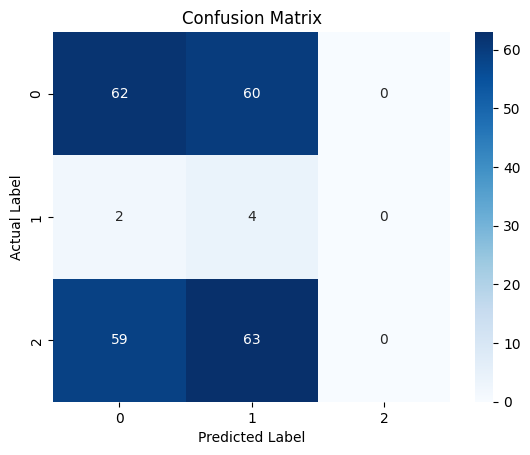

Epoch 1/8
18/18 [==============================] - 18s 169ms/step - loss: 0.0000e+00 - accuracy: 0.2531 - val_loss: 0.0000e+00 - val_accuracy: 0.3457
Epoch 2/8
18/18 [==============================] - 1s 81ms/step - loss: 0.0000e+00 - accuracy: 0.2531 - val_loss: 0.0000e+00 - val_accuracy: 0.0106
Epoch 3/8
18/18 [==============================] - 1s 78ms/step - loss: 0.0000e+00 - accuracy: 0.2496 - val_loss: 0.0000e+00 - val_accuracy: 0.0957
Epoch 4/8
18/18 [==============================] - 2s 104ms/step - loss: 0.0000e+00 - accuracy: 0.2299 - val_loss: 0.0000e+00 - val_accuracy: 0.0266
Epoch 5/8
18/18 [==============================] - 2s 100ms/step - loss: 0.0000e+00 - accuracy: 0.2763 - val_loss: 0.0000e+00 - val_accuracy: 0.2819
Epoch 6/8
18/18 [==============================] - 2s 95ms/step - loss: 0.0000e+00 - accuracy: 0.2531 - val_loss: 0.0000e+00 - val_accuracy: 0.3085
Epoch 7/8
18/18 [==============================] - 1s 78ms/step - loss: 0.0000e+00 - accuracy: 0.2602 - val_

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


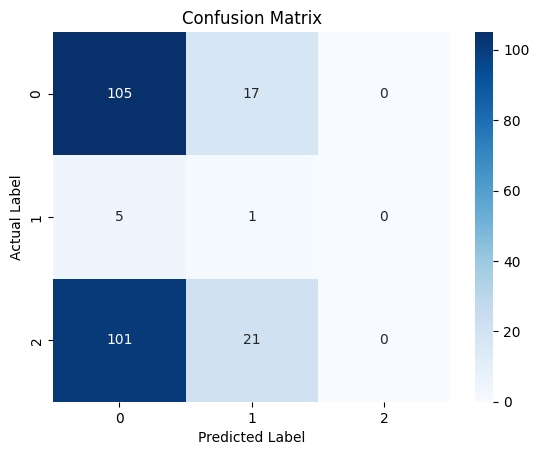

In [90]:

print("RNN")
num_layer = [2,3]
dropout_rate = [0.3,0.7]
for i in range(2):
    model = my_models_function("RNN",num_layer[i],dropout_rate[i])
    model.fit(X_train, y_train, batch_size=32, epochs=8, validation_split=0.25)
    print("RNN model for num_layer: ",num_layer[i],"dropout rate: ",dropout_rate[i])
    evaluate_model(model, X_test, y_test)  

GRU
Epoch 1/8
18/18 [==============================] - 16s 252ms/step - loss: 0.0000e+00 - accuracy: 0.4064 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 3s 144ms/step - loss: 0.0000e+00 - accuracy: 0.4938 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 3s 144ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 4/8
18/18 [==============================] - 3s 145ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 5/8
18/18 [==============================] - 3s 144ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 6/8
18/18 [==============================] - 3s 173ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 7/8
18/18 [==============================] - 3s 150ms/step - loss: 0.0000e+00 - accuracy: 0.499

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


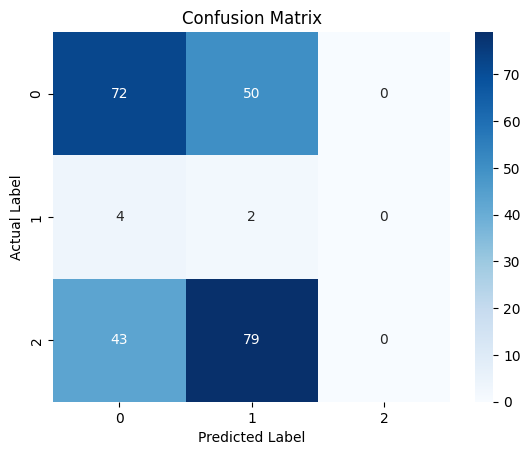

Epoch 1/8
18/18 [==============================] - 24s 400ms/step - loss: 0.0000e+00 - accuracy: 0.3440 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 3s 164ms/step - loss: 0.0000e+00 - accuracy: 0.3102 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 5s 267ms/step - loss: 0.0000e+00 - accuracy: 0.3922 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 4/8
18/18 [==============================] - 2s 134ms/step - loss: 0.0000e+00 - accuracy: 0.4153 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 5/8
18/18 [==============================] - 2s 134ms/step - loss: 0.0000e+00 - accuracy: 0.4242 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 6/8
18/18 [==============================] - 2s 135ms/step - loss: 0.0000e+00 - accuracy: 0.4492 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 7/8
18/18 [==============================] - 3s 144ms/step - loss: 0.0000e+00 - accuracy: 0.4474 - 

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


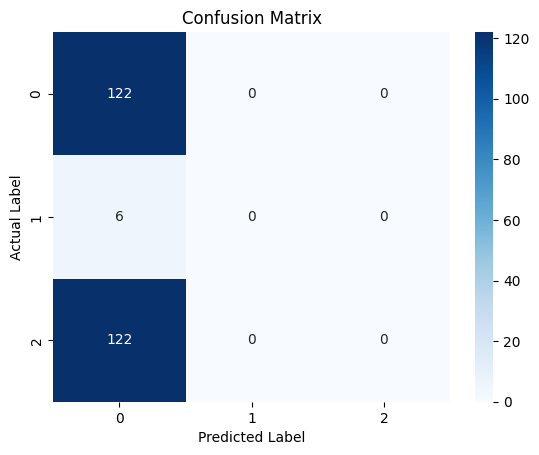

In [91]:

print("GRU")
for i in range(2):
    model = my_models_function("GRU",num_layer[i],dropout_rate[i])
    model.fit(X_train, y_train, batch_size=32, epochs=8, validation_split=0.25)
    print("GRU model for num_layer: ",num_layer[i],"dropout rate: ",dropout_rate[i])
    evaluate_model(model, X_test, y_test)  

LSTM
Epoch 1/8
18/18 [==============================] - 21s 361ms/step - loss: 0.0000e+00 - accuracy: 0.4920 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 3s 176ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 3s 185ms/step - loss: 0.0000e+00 - accuracy: 0.4973 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 4/8
18/18 [==============================] - 6s 350ms/step - loss: 0.0000e+00 - accuracy: 0.4938 - val_loss: 0.0000e+00 - val_accuracy: 0.3138
Epoch 5/8
18/18 [==============================] - 4s 222ms/step - loss: 0.0000e+00 - accuracy: 0.4902 - val_loss: 0.0000e+00 - val_accuracy: 0.2021
Epoch 6/8
18/18 [==============================] - 4s 202ms/step - loss: 0.0000e+00 - accuracy: 0.4902 - val_loss: 0.0000e+00 - val_accuracy: 0.2606
Epoch 7/8
18/18 [==============================] - 3s 192ms/step - loss: 0.0000e+00 - accuracy: 0.50

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


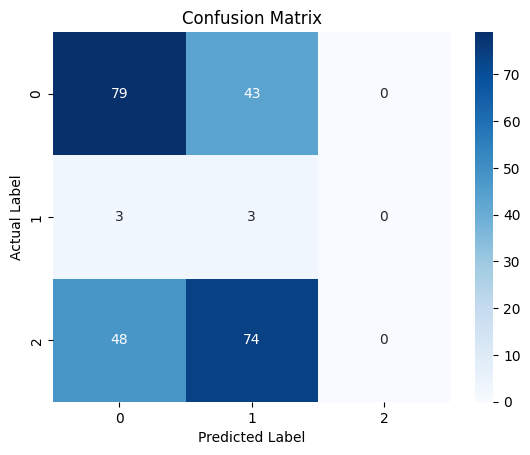

Epoch 1/8
18/18 [==============================] - 17s 301ms/step - loss: 0.0000e+00 - accuracy: 0.2656 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 3s 161ms/step - loss: 0.0000e+00 - accuracy: 0.2549 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 4s 202ms/step - loss: 0.0000e+00 - accuracy: 0.3102 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 4/8
18/18 [==============================] - 4s 207ms/step - loss: 0.0000e+00 - accuracy: 0.4029 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 5/8
18/18 [==============================] - 3s 182ms/step - loss: 0.0000e+00 - accuracy: 0.4581 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 6/8
18/18 [==============================] - 3s 160ms/step - loss: 0.0000e+00 - accuracy: 0.4848 - val_loss: 0.0000e+00 - val_accuracy: 0.3511
Epoch 7/8
18/18 [==============================] - 3s 178ms/step - loss: 0.0000e+00 - accuracy: 0.4670 - 

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


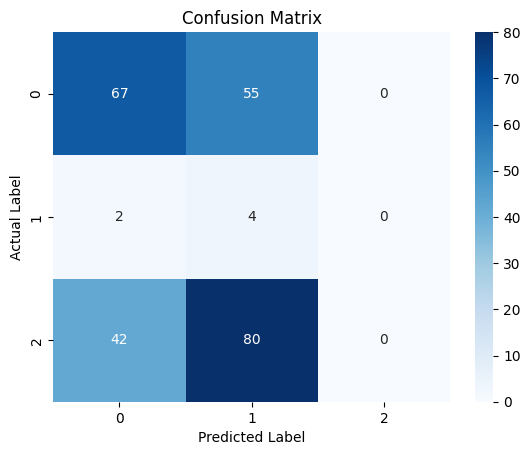

In [92]:

print("LSTM")
for i in range(2):
    model = my_models_function("LSTM",num_layer[i],dropout_rate[i])
    model.fit(X_train, y_train, batch_size=32, epochs=8, validation_split=0.25)
    print("LSTM model for num_layer: ",num_layer[i],"dropout rate: ",dropout_rate[i])
    evaluate_model(model, X_test, y_test)  

BiLSTM
Epoch 1/8
18/18 [==============================] - 37s 666ms/step - loss: 0.0000e+00 - accuracy: 0.0642 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 6s 359ms/step - loss: 0.0000e+00 - accuracy: 0.4813 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 8s 463ms/step - loss: 0.0000e+00 - accuracy: 0.4848 - val_loss: 0.0000e+00 - val_accuracy: 0.2287
Epoch 4/8
18/18 [==============================] - 9s 488ms/step - loss: 0.0000e+00 - accuracy: 0.4955 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 5/8
18/18 [==============================] - 10s 537ms/step - loss: 0.0000e+00 - accuracy: 0.4955 - val_loss: 0.0000e+00 - val_accuracy: 0.2340
Epoch 6/8
18/18 [==============================] - 8s 477ms/step - loss: 0.0000e+00 - accuracy: 0.4955 - val_loss: 0.0000e+00 - val_accuracy: 0.3670
Epoch 7/8
18/18 [==============================] - 6s 344ms/step - loss: 0.0000e+00 - accuracy: 0

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


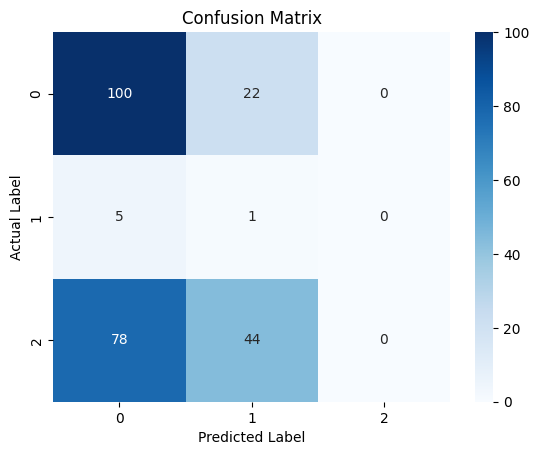

Epoch 1/8
18/18 [==============================] - 24s 476ms/step - loss: 0.0000e+00 - accuracy: 0.2870 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 2/8
18/18 [==============================] - 5s 275ms/step - loss: 0.0000e+00 - accuracy: 0.4153 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 3/8
18/18 [==============================] - 6s 344ms/step - loss: 0.0000e+00 - accuracy: 0.4724 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 4/8
18/18 [==============================] - 9s 511ms/step - loss: 0.0000e+00 - accuracy: 0.4884 - val_loss: 0.0000e+00 - val_accuracy: 0.5160
Epoch 5/8
18/18 [==============================] - 8s 411ms/step - loss: 0.0000e+00 - accuracy: 0.4991 - val_loss: 0.0000e+00 - val_accuracy: 0.0479
Epoch 6/8
18/18 [==============================] - 7s 401ms/step - loss: 0.0000e+00 - accuracy: 0.4242 - val_loss: 0.0000e+00 - val_accuracy: 0.2181
Epoch 7/8
18/18 [==============================] - 7s 370ms/step - loss: 0.0000e+00 - accuracy: 0.4777 - 

d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python64\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


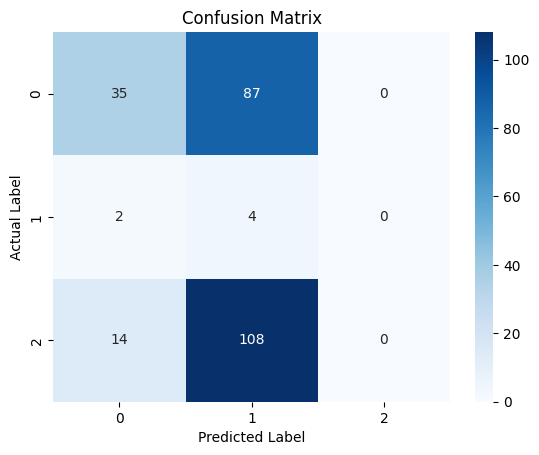

In [93]:

print("BiLSTM")
for i in range(2):
    model = my_models_function("BiLSTM",num_layer[i],dropout_rate[i])
    model.fit(X_train, y_train, batch_size=32, epochs=8, validation_split=0.25)
    print("BiLSTM model for num_layer: ",num_layer[i],"dropout rate: ",dropout_rate[i])
    evaluate_model(model, X_test, y_test)  